In [1]:
library(tidyverse)
library(blur)
library(cowplot)

load("../../data/genesis/gi.net")
load("../../data/genesis/genesis.RData")
hyper <- read_delim("hyperparams.tsv", ";", col_types = "ccdd")

experiments <- list.dirs(recursive = F)
experiments <- gsub("./", "", experiments, fixed = T)
experiments <- experiments[lapply(experiments, nchar) == 30]

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.1     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



# GENESIS

For reference, the parameters on the GENESIS dataset were eta = 2.38 and lambda = 102.12.

In [2]:
load("../evo/cones.gi.RData")
genesis_results <- cones %>%
    rename(module = cluster) %>%
    mutate(exp = "genesis", causal = NA)
rm(cones, info, test, time.taken)

# Consistency

In [3]:
cons <- lapply(experiments, function(e) {
    resfile <- list.files(path = e, pattern = "cones.evo.chi2.consistency.*", full.names = T)
    solfile <- list.files(path = e, pattern = "causal.RData", full.names = T)
    load(resfile)
    load(solfile)
    cones$exp <- e
    cones$causal <- causal
    cones
}) %>% do.call(rbind, .)

plotHyper <- filter(hyper, model_selection == "consistency") %>%
    ggplot(aes(x = log10(lambda), y = log10(eta))) +
        geom_hex() +
        labs(title = "Consistency") +
        theme_minimal()

Warning message:
“Removed 4836 rows containing non-finite values (stat_boxplot).”

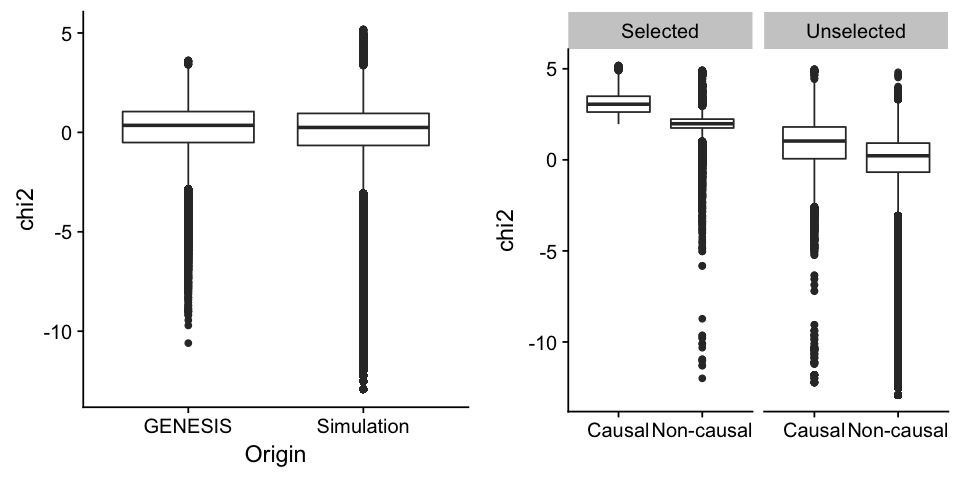

In [4]:
A <- rbind(genesis_results, cons) %>%
    ggplot(aes(x = ifelse(exp == "genesis", "GENESIS", "Simulation"), y = log(c))) + 
        geom_boxplot() +
        labs(x = "Origin", y = "chi2")

B <- ggplot(cons, aes(x = ifelse(causal, "Causal", "Non-causal"), y = log(c))) + 
    geom_boxplot() +
    facet_grid(. ~ ifelse(selected, "Selected", "Unselected")) +
    labs(x = "", y = "chi2")

options(repr.plot.width=8, repr.plot.height=4)
plot_grid(A, B)

Loading required package: sna
Loading required package: statnet.common

Attaching package: ‘statnet.common’

The following object is masked from ‘package:base’:

    order

Loading required package: network
network: Classes for Relational Data
Version 1.13.0 created on 2015-08-31.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
                    Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Martina Morris, University of Washington
                    Skye Bender-deMoll, University of Washington
 For citation information, type citation("network").
 Type help("network-package") to get started.

sna: Tools for Social Network Analysis
Version 2.4 created on 2016-07-23.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
 For citation information, type citation("sna").
 Type help(package="sna") to get started.



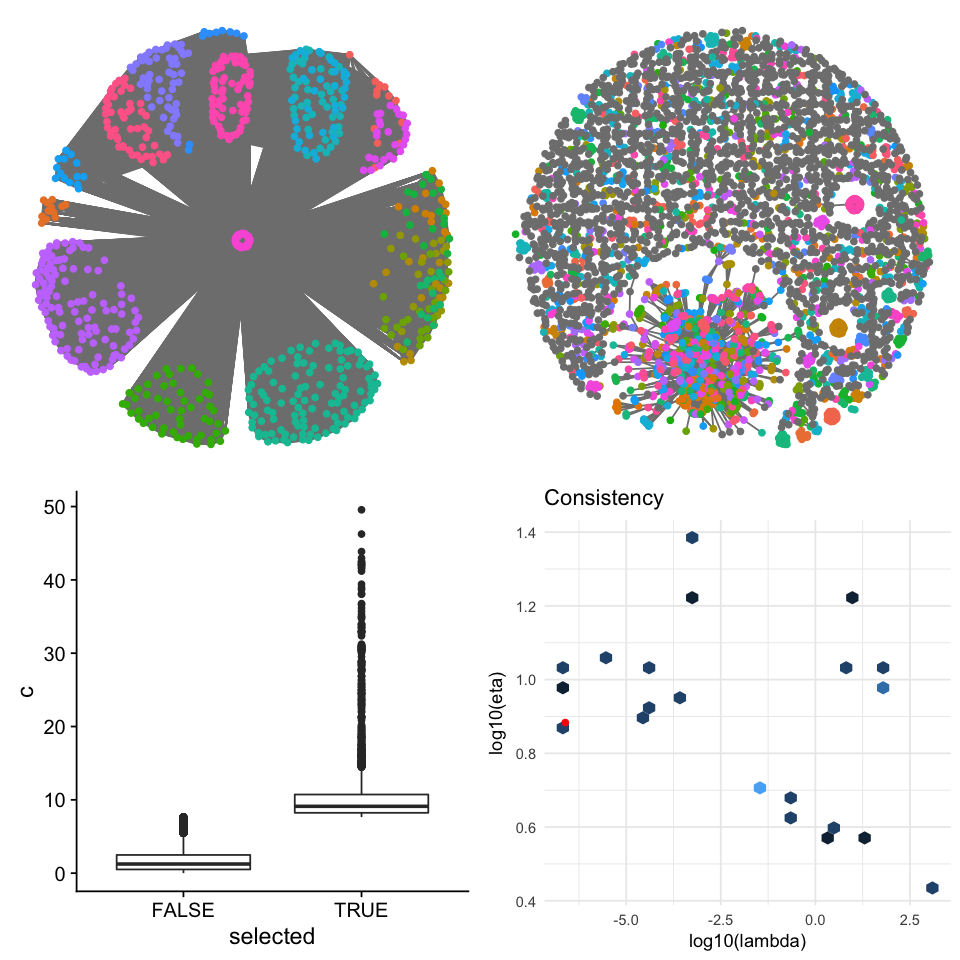

In [5]:
plot_subnets <- function(cones, e, s) {
    
    hy <- filter(hyper, model_selection == s & experiment == e)
    
    causal <- filter(cones, exp == e) %>%
        filter(causal) %>%
        .$snp %>%
        as.character %>%
        plot_subnetwork(genesis, net, .) +
            guides(color=FALSE)

    detected <- filter(cones, exp == e) %>%
        filter(selected) %>%
        .$snp %>%
        as.character %>%
        plot_subnetwork(genesis, net, .) +
            guides(color=FALSE)

    box <- filter(cones, exp == e) %>%
        ggplot(aes(x = selected, y = c)) +
        geom_boxplot()
    
    hyperplot <- plotHyper +
        geom_point(data = hy, aes(x=log10(lambda), y=log10(eta)), colour="red") +
        guides(fill=FALSE)

    plot_grid(causal, detected, box, hyperplot) %>% print

}

options(repr.plot.width=8, repr.plot.height=8)
e <- filter(hyper, lambda < 1e-6 & model_selection == "consistency")$experiment[1]
plot_subnets(cons, e, "consistency")

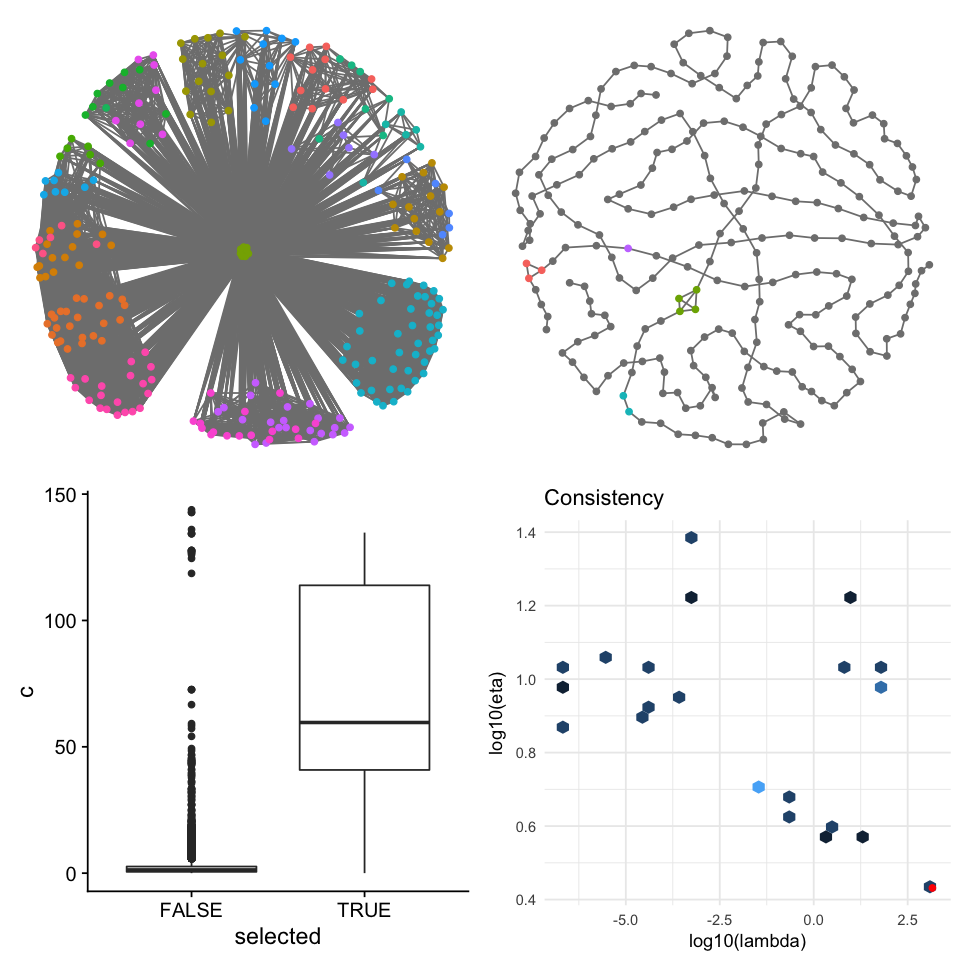

In [8]:
e <- filter(hyper, lambda > 1e2 & eta > 2 & model_selection == "consistency")$experiment[1]
plot_subnets(cons, e, "consistency")

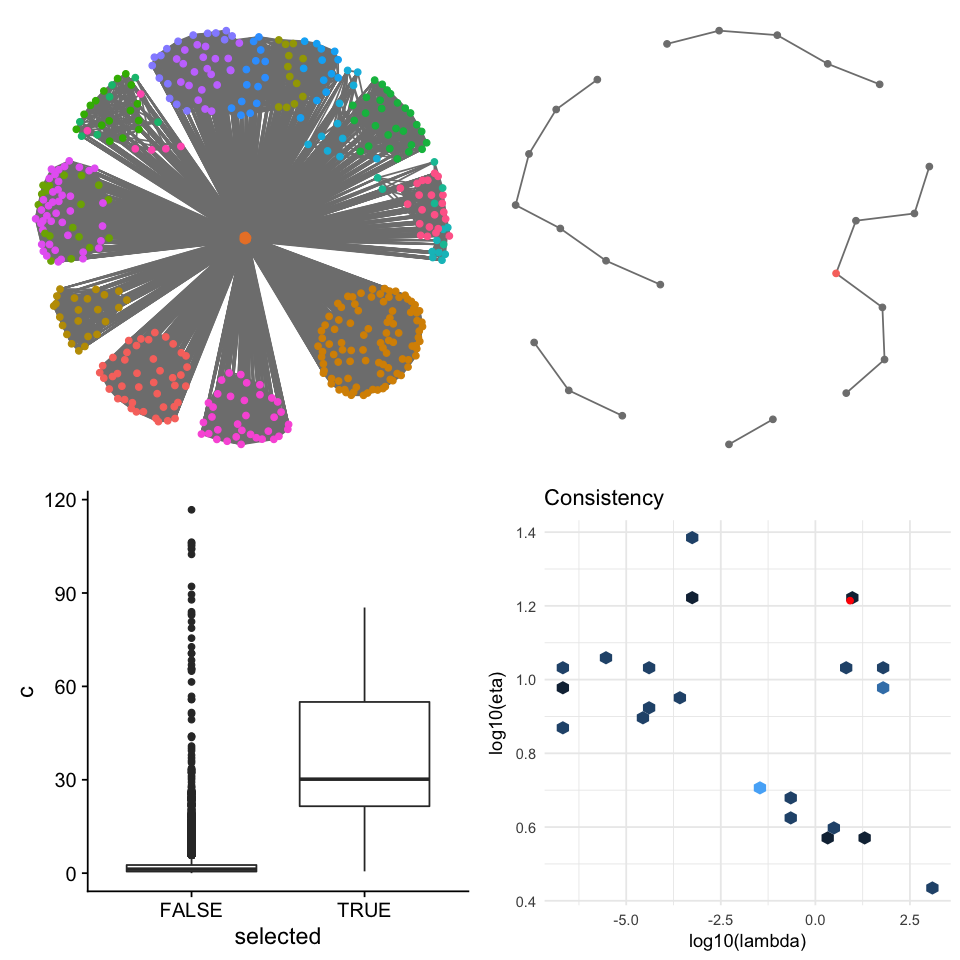

In [9]:
e <- filter(hyper, lambda > 1 & eta > 1 & model_selection == "consistency")$experiment[1]
plot_subnets(cons, e, "consistency")

# BIC

In [10]:
bic <- lapply(experiments, function(e) {
    resfile <- list.files(path = e, pattern = "cones.evo.chi2.bic.*", full.names = T)
    solfile <- list.files(path = e, pattern = "causal.RData", full.names = T)
    load(resfile)
    load(solfile)
    cones$exp <- e
    cones$causal <- causal
    cones
}) %>% do.call(rbind, .)

plotHyper <- filter(hyper, model_selection == "bic") %>%
ggplot(aes(x = log10(lambda), y = log10(eta))) +
    geom_hex() +
    labs(title = "BIC") +
    theme_minimal()

Warning message:
“Removed 4836 rows containing non-finite values (stat_boxplot).”

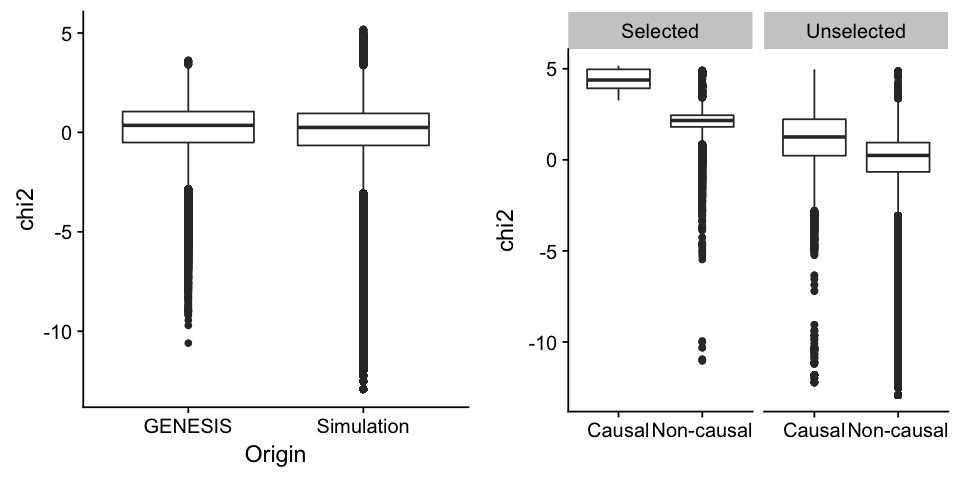

In [11]:
A <- rbind(genesis_results, bic) %>%
    ggplot(aes(x = ifelse(exp == "genesis", "GENESIS", "Simulation"), y = log(c))) + 
        geom_boxplot() +
        labs(x = "Origin", y = "chi2")

B <- ggplot(bic, aes(x = ifelse(causal, "Causal", "Non-causal"), y = log(c))) + 
    geom_boxplot() +
    facet_grid(. ~ ifelse(selected, "Selected", "Unselected")) +
    labs(x = "", y = "chi2")

options(repr.plot.width=8, repr.plot.height=4)
plot_grid(A, B)

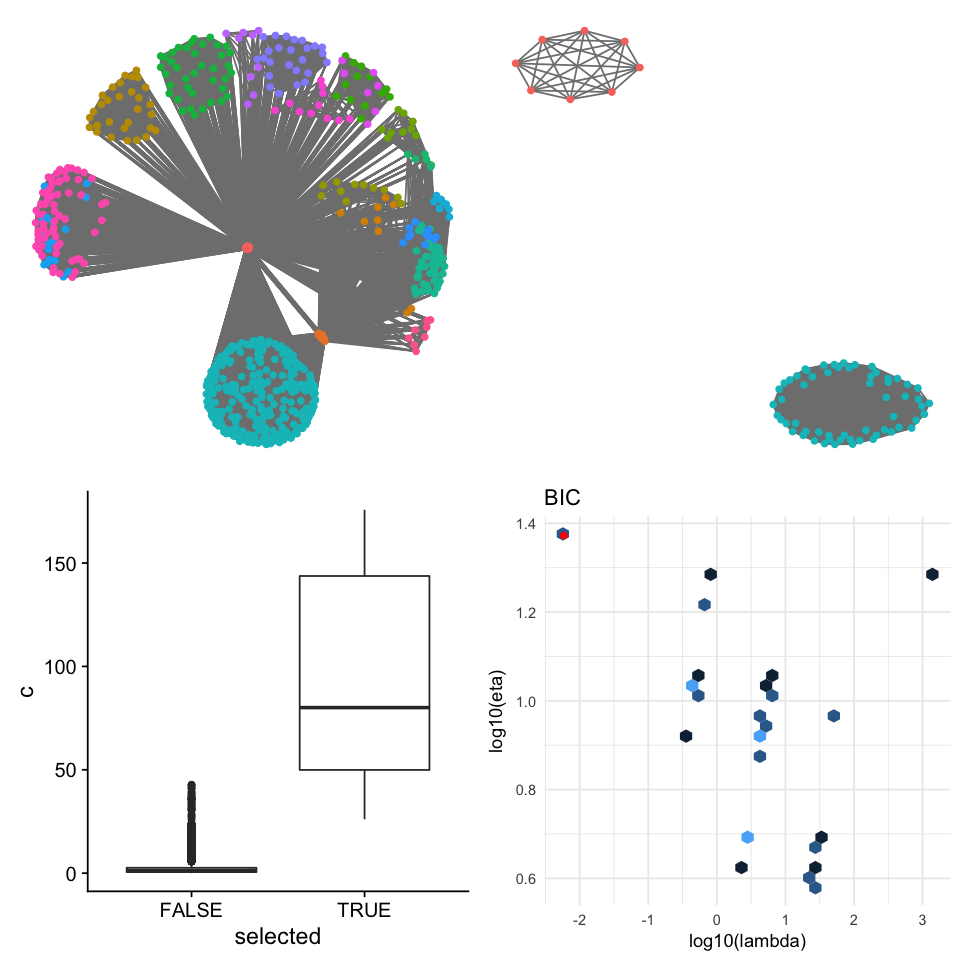

In [12]:
options(repr.plot.width=8, repr.plot.height=8)
e <- filter(hyper, lambda < 0.1 & model_selection == "bic")$experiment[1]
plot_subnets(bic, e, "bic")

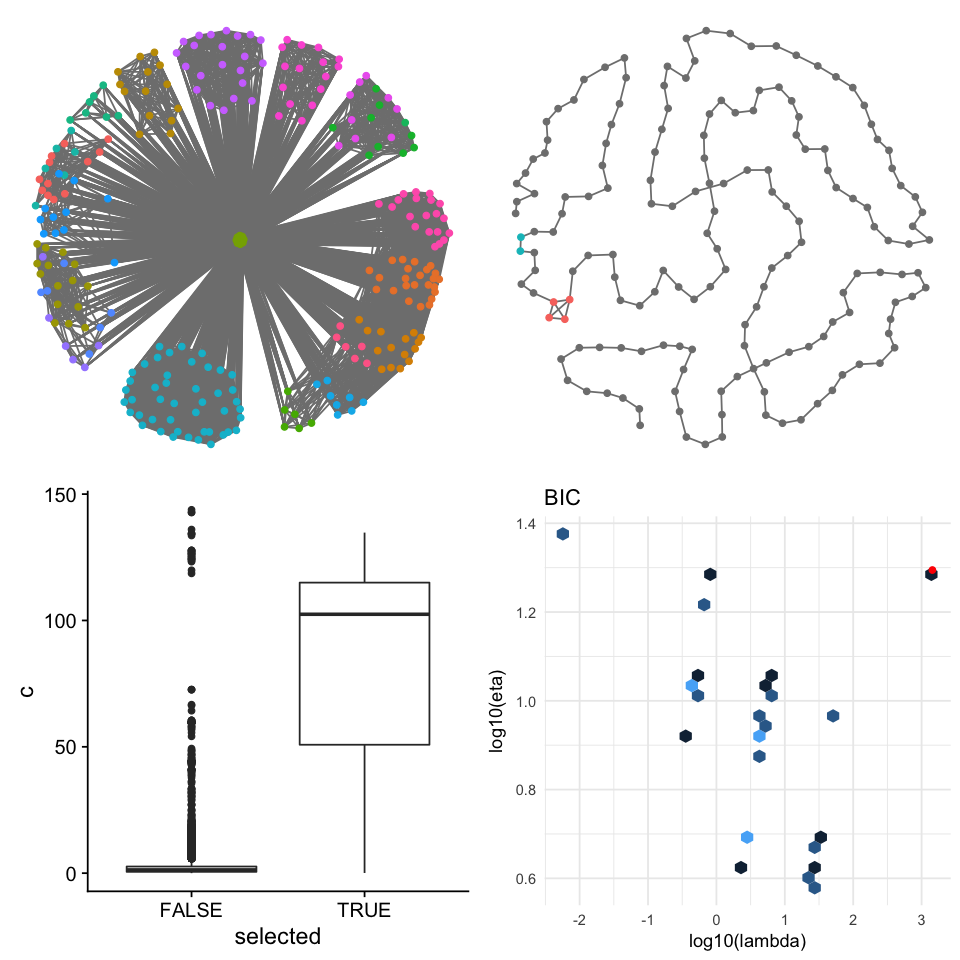

In [13]:
e <- filter(hyper, lambda > 1000 & model_selection == "bic")$experiment[1]
plot_subnets(bic, e, "bic")

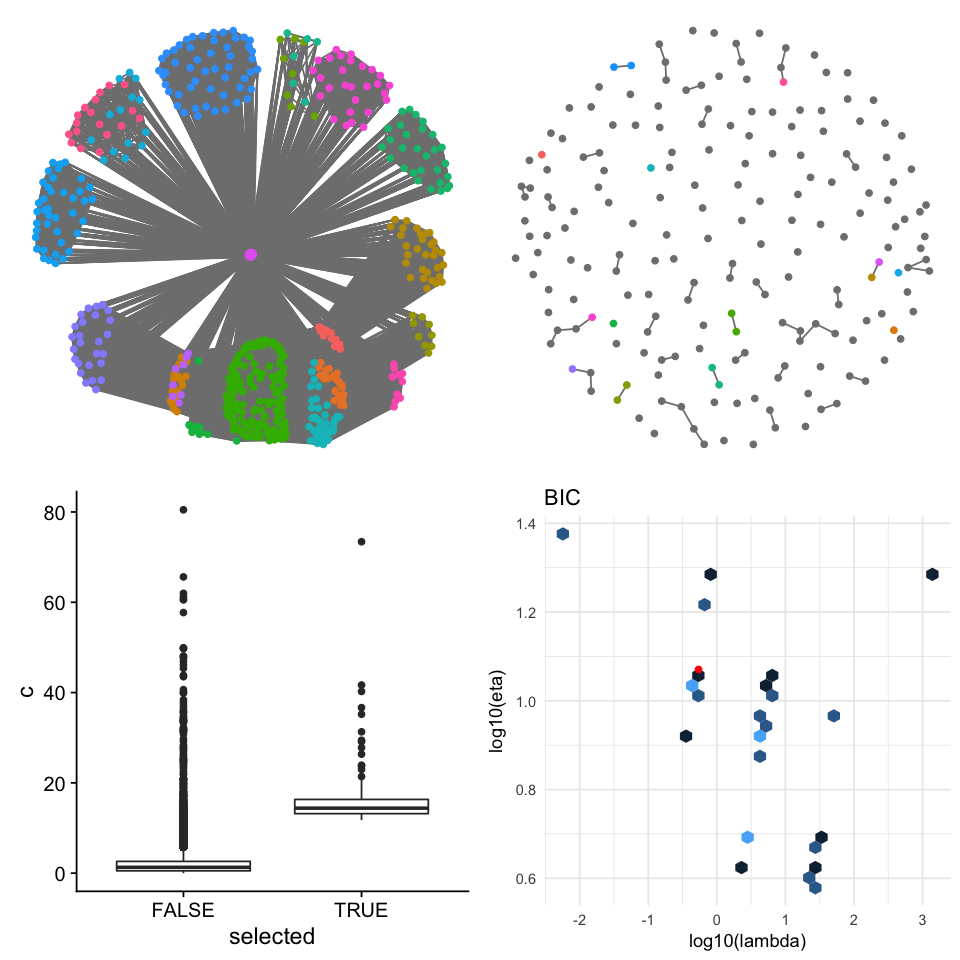

In [14]:
e <- filter(hyper, eta < 10^(1.2) & eta > 10 & model_selection == "bic")$experiment[1]
plot_subnets(bic, e, "bic")

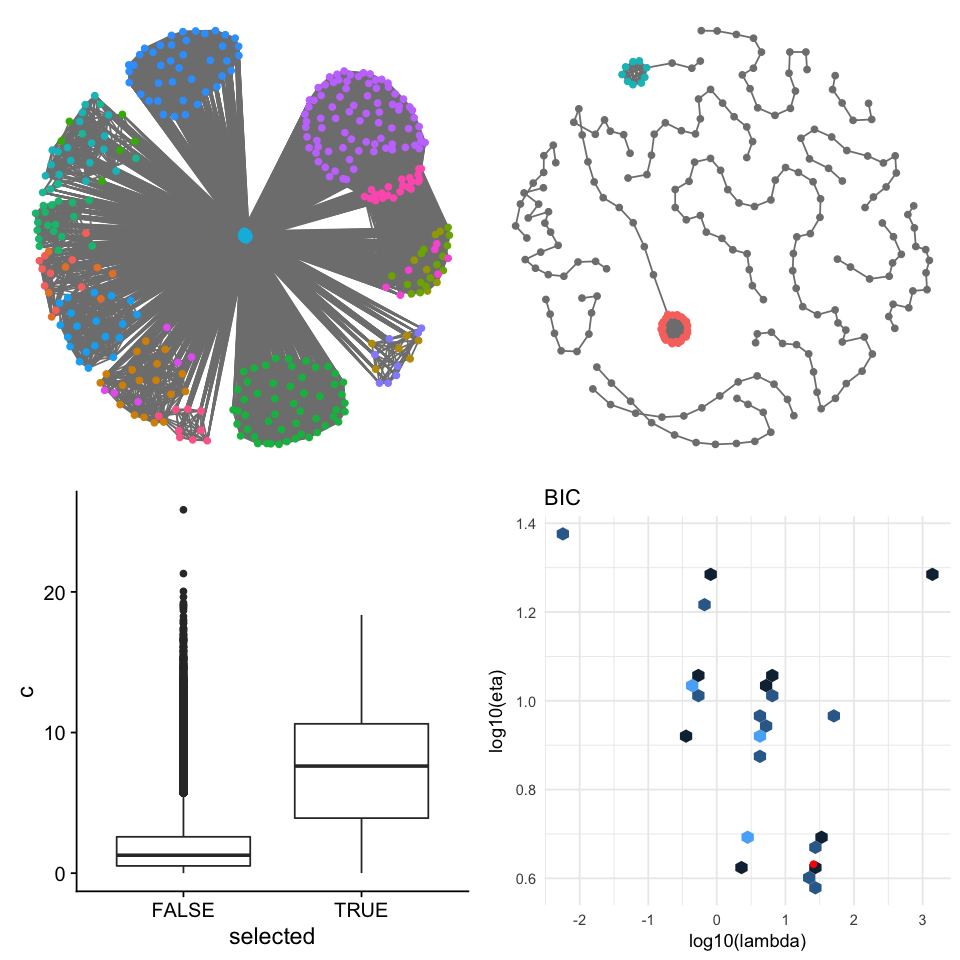

In [15]:
e <- filter(hyper, eta < 10^(0.8) & model_selection == "bic")$experiment[1]
plot_subnets(bic, e, "bic")

# AIC

In [16]:
aic <- lapply(experiments, function(e) {
    resfile <- list.files(path = e, pattern = "cones.evo.chi2.aic.*", full.names = T)
    solfile <- list.files(path = e, pattern = "causal.RData", full.names = T)
    load(resfile)
    load(solfile)
    cones$exp <- e
    cones$causal <- causal
    cones
}) %>% do.call(rbind, .)

plotHyper <- filter(hyper, model_selection == "aic") %>%
ggplot(aes(x = log10(lambda), y = log10(eta))) +
    geom_hex() +
    labs(title = "AIC") +
    theme_minimal()

Warning message:
“Removed 4836 rows containing non-finite values (stat_boxplot).”

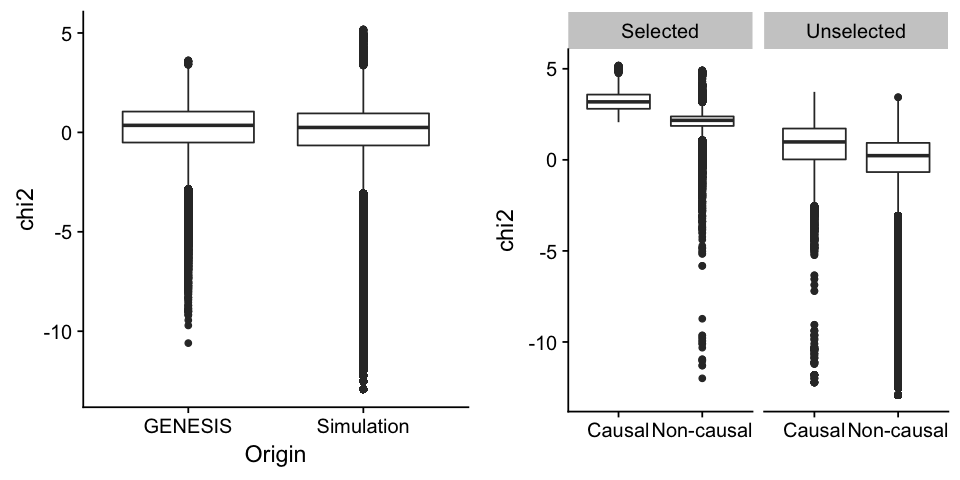

In [17]:
A <- rbind(genesis_results, aic) %>%
    ggplot(aes(x = ifelse(exp == "genesis", "GENESIS", "Simulation"), y = log(c))) + 
        geom_boxplot() +
        labs(x = "Origin", y = "chi2")

B <- ggplot(aic, aes(x = ifelse(causal, "Causal", "Non-causal"), y = log(c))) + 
    geom_boxplot() +
    facet_grid(. ~ ifelse(selected, "Selected", "Unselected")) +
    labs(x = "", y = "chi2")

options(repr.plot.width=8, repr.plot.height=4)
plot_grid(A, B)

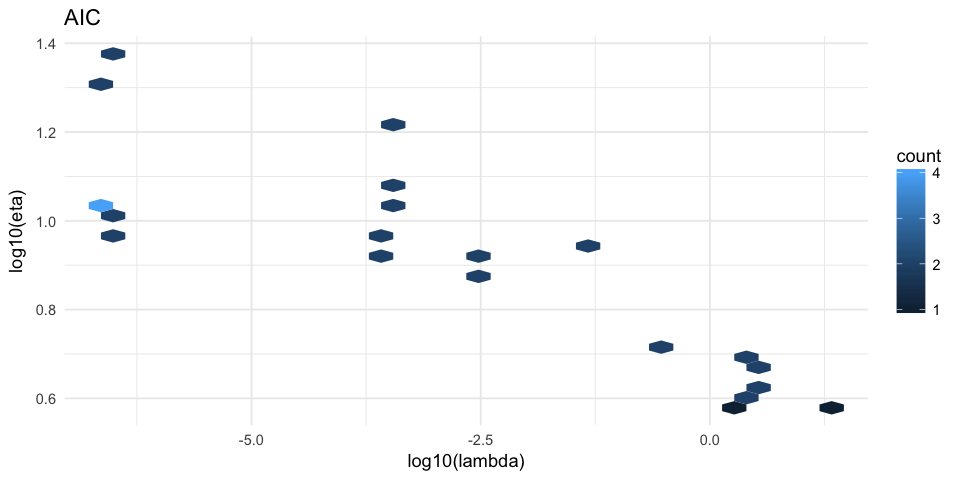

In [18]:
plotHyper